In [166]:
from rpy2 import robjects
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import multiprocessing as mp
import pandas as pd
import numpy as np
import datetime
import yaml
import os
# Convert pandas dataframe
from rpy2.robjects import pandas2ri
pandas2ri.activate()
# Suppress R warnings in python:
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

output_dir = 'output_16-04-init/'
        
dept_avail = os.listdir(output_dir)

rainfall = pd.read_csv('haiti-data/fromAzman/rainfall.csv', index_col = 0, parse_dates = True)
cases    = pd.read_csv('haiti-data/fromAzman/cases_corrected.csv', index_col=0, parse_dates =True)
rain     = pd.read_csv('haiti-data/proj/rainfall.csv', index_col = 0, parse_dates = True)

compartments = ['S', 'I', 'A', 'RA1', 'RA2', 'RA3', 'RI1', 'RI2', 'RI3', 'W', 'B', 'cases', 'C',
                 "VSd", "VRI1d", "VRI2d", "VRI3d", "VRA1d", "VRA2d", "VRA3d",
                 "VSdd", "VRI1dd", "VRI2dd", "VRI3dd", "VRA1dd", "VRA2dd", "VRA3dd",
                 "VSd_alt", "VRI1d_alt", "VRI2d_alt", "VRI3d_alt", "VRA1d_alt", "VRA2d_alt", "VRA3d_alt",
                 "VSdd_alt", "VRI1dd_alt", "VRI2dd_alt", "VRI3dd_alt", "VRA1dd_alt", "VRA2dd_alt", "VRA3dd_alt"]

stream = open('haiti-data/input_parameters.yaml', 'r')
input_parameters = yaml.load(stream)

dept_name = [list(pop.keys())[0] for pop in input_parameters['population']]

t_start = input_parameters['t_start']
t_for = datetime.date(2029,12,20)

index = pd.DatetimeIndex(start =  t_start,  end = t_for, freq = 'W-SAT')

nsim = 500
run_lvl = 3
n_proc = 5

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


In [131]:
def make_genuine_mobility_file():
    covar_init = pd.concat([cases[t_start:]]*6, ignore_index=True)[0:-506]
    covar_init.index = pd.DatetimeIndex(start =  datetime.date(2010,10,23), 
                                      end = t_for, freq = 'W-SAT')
    covar_init.to_csv('covar_mob.csv', index_label='date')
    return covar_init

In [154]:
class VaccinationScenario():
    def __init__(self, course_year, percent_completely_unvaccinated, percent_onedose, percent_twodoses, not_dep = []):
        pop = {'Artibonite':1727524,
        'Centre':746236,
        'Grande_Anse':468301,
        'Nippes':342525,
        'Nord':1067177,
        'Nord-Est':393967,
        'Nord-Ouest':728807,
        'Ouest':4029705,
        'Sud':774976,
        'Sud-Est':632601}
        ocv_order = ['Centre', 'Artibonite','Ouest','Nord-Ouest','Nord','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse']
        self.t_vacc_start = {}
        self.t_vacc_end = {}
        self.p1d_reg = {}
        self.r_v_year = {}

        #20% completely unvaccinated, 10% one-dose only, 70% two doses
        t_init = datetime.date(2019,1,12)
        days_per_departement = int((course_year*365)/len(ocv_order))

        for i, dp in enumerate(ocv_order):
            if dp not in not_dep:
                self.t_vacc_start[dp] = t_init + datetime.timedelta(days=i*days_per_departement)
                self.t_vacc_end[dp] = t_init + datetime.timedelta(days=(i+1)*days_per_departement)
                self.p1d_reg[dp] = percent_onedose/(percent_onedose + percent_twodoses)
                self.r_v_year[dp] = pop[dp]*(100-percent_completely_unvaccinated)/100/days_per_departement * 365.25

            else:
                self.t_vacc_start[dp] = t_init + datetime.timedelta(days=i*days_per_departement)
                self.t_vacc_end[dp] = t_init + datetime.timedelta(days=(i+1)*days_per_departement)
                self.p1d_reg[dp] = 0
                self.r_v_year[dp] =0


S0 = VaccinationScenario(1, 100, 0.1, 0.1, not_dep = dept_avail)
S1 = VaccinationScenario(2, 20, 10, 70)
S2 = VaccinationScenario(2, 20, 10, 70, not_dep=['Ouest','Nord-Ouest','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse'])
S3 = VaccinationScenario(5, 20, 10, 70)
S4 = VaccinationScenario(5, 20, 10, 70, not_dep=['Nord-Ouest','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse'])
S25 = VaccinationScenario(2, 3.33, 1.67, 95)

In [133]:
def run_sim(dp):
    # see second answer of https://stackoverflow.com/questions/25175530/can-rpy2-code-be-run-in-parallel on why it starts different 
    # R instances
    r_source = robjects.r['source'];
    dept_data = {}
    r_options = robjects.r['options']
    r_options(warn=-1)
    robjects.r('departement <- "' + dp + '"')
    robjects.r('output_dir <- "' + output_dir + '"')
    robjects.r('scenario <- "' + scenario_str + '"')
    robjects.r('run_level <- ' + str(run_lvl))
    robjects.r('nsim <- ' + str(nsim))
    robjects.r('t_vacc_start <- "' + str(scenario.t_vacc_start[dp]) + '"')
    robjects.r('t_vacc_end  <- "' +  str(scenario.t_vacc_end[dp]) + '"')
    robjects.r('p1d_reg <- ' +       str(scenario.p1d_reg[dp]))
    robjects.r('r_v_year <- ' +      str(scenario.r_v_year[dp]))
    robjects.r('cases_ext <- 1')
    r_source('/Users/chadi/Documents/phd/haiti-ocv-pomp/scripts/forecast_haitiOCV_mob.R')
    for comp in compartments:
        #temp = pandas2ri.ri2py(robjects.r[comp])
        temp = robjects.r[comp]
        temp.index = index
        temp.drop('date',axis=1, inplace = True)
        dept_data[comp] = temp
    return (dp, dept_data, robjects.r['params'], robjects.r('names(params)'))
    

#### Forecasting with no vaccination

In [206]:
all_data = {}
pars_dic = {}

scenario = S0
scenario_str = 'S0'
make_genuine_mobility_file()
with mp.Pool(processes=n_proc) as pool:
    for dp, dept_data, params, params_name in pool.imap_unordered(run_sim, dept_avail):
        all_data[dp] = dept_data
        pars_dic[dp] = params
        params_name = params_name
        

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  after removing the cwd from sys.path.
R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ✔ ggplot2 3.1.0       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  

R[write to console]: ✔ ggplot2 3.1.0       ✔ purrr   0.3.2  
✔ tibble  2.1.1       

### Extracting best performing parameters

In [144]:
all_params = pd.DataFrame(0, columns = params_name, index= dept_avail)
for key, value in pars_dic.items():
    all_params.loc[key] = value        
        
# Convert years in mean duration of days day
rates = [ "gammaI", "gammaA", "rhoA", 'rhoI', 'mu_B']
params_disp = all_params.copy()
params_disp.loc[:,'rhoI'] = params_disp.loc[:,'XrhoI'] * params_disp.loc[:,'rhoA']
params_disp.loc[:,'thetaA'] = params_disp.loc[:,'XthetaA'] * params_disp.loc[:,'thetaI']
params_disp.drop(['mu', 'alpha', 'XrhoI', 'XthetaA', 't_vacc_start', 't_vacc_end', 'p1d_reg', 'r_v_year', 'H', 'D', 'Rtot_0'], axis =1, inplace = True)
for p in rates:
    params_disp.loc[:,p] =  1/(params_disp.loc[:,p]/365.25);
    
params_disp = params_disp.reindex(columns=sorted(params_disp.columns));
params_disp

,betaB,cas_def,cases_ext,epsilon,foi_add,gammaA,gammaI,k,lambdaR,mu_B,r,rhoA,rhoI,sigma,std_W,thetaA,thetaI
Artibonite,0.516191,0.464975,1.0,0.975027,1.530994e-06,2.0,2.0,101.2216,0.277424,2.742176,0.313604,2920.0,2920.0,0.25,0.008172,0.000015,0.000345
Sud-Est,1.384372,0.460000,1.0,0.975027,6.105491e-07,2.0,2.0,101.2216,0.277424,2.742176,0.313604,2920.0,2920.0,0.25,0.008172,0.000015,0.000345
Nippes,2.999928,0.460000,1.0,0.975027,3.056857e-07,2.0,2.0,101.2216,0.277424,2.742176,0.313604,2920.0,2920.0,0.25,0.008172,0.000015,0.000345
Nord-Est,3.248645,0.460000,1.0,0.975027,8.209611e-07,2.0,2.0,101.2216,0.277424,2.742176,0.313604,2920.0,2920.0,0.25,0.008172,0.000015,0.000345
Ouest,0.106151,0.460000,1.0,0.975027,1.029080e-07,2.0,2.0,101.2216,0.277424,2.742176,0.313604,2920.0,2920.0,0.25,0.008172,0.000015,0.000345
Centre,1.977686,0.460000,1.0,0.975027,1.065046e-05,2.0,2.0,101.2216,0.277424,2.742176,0.313604,2920.0,2920.0,0.25,0.008172,0.000015,0.000345
Nord,0.589541,0.460000,1.0,0.975027,5.319736e-07,2.0,2.0,101.2216,0.277424,2.742176,0.313604,2920.0,2920.0,0.25,0.008172,0.000015,0.000345
Sud,1.305966,0.460000,1.0,0.975027,1.030357e-06,2.0,2.0,101.2216,0.277424,2.742176,0.313604,2920.0,2920.0,0.25,0.008172,0.000015,0.000345
Nord-Ouest,1.141691,0.460000,1.0,0.975027,5.855759e-07,2.0,2.0,101.2216,0.277424,2.742176,0.313604,2920.0,2920.0,0.25,0.008172,0.000015,0.000345
Grande_Anse,2.823539,0.460000,1.0,0.975027,8.762740e-07,2.0,2.0,101.2216,0.277424,2.742176,0.313604,2920.0,2920.0,0.25,0.008172,0.000015,0.000345


In [209]:
all_data['Ouest']['cases'][:datetime.date(2015,7,1)] = np.nan

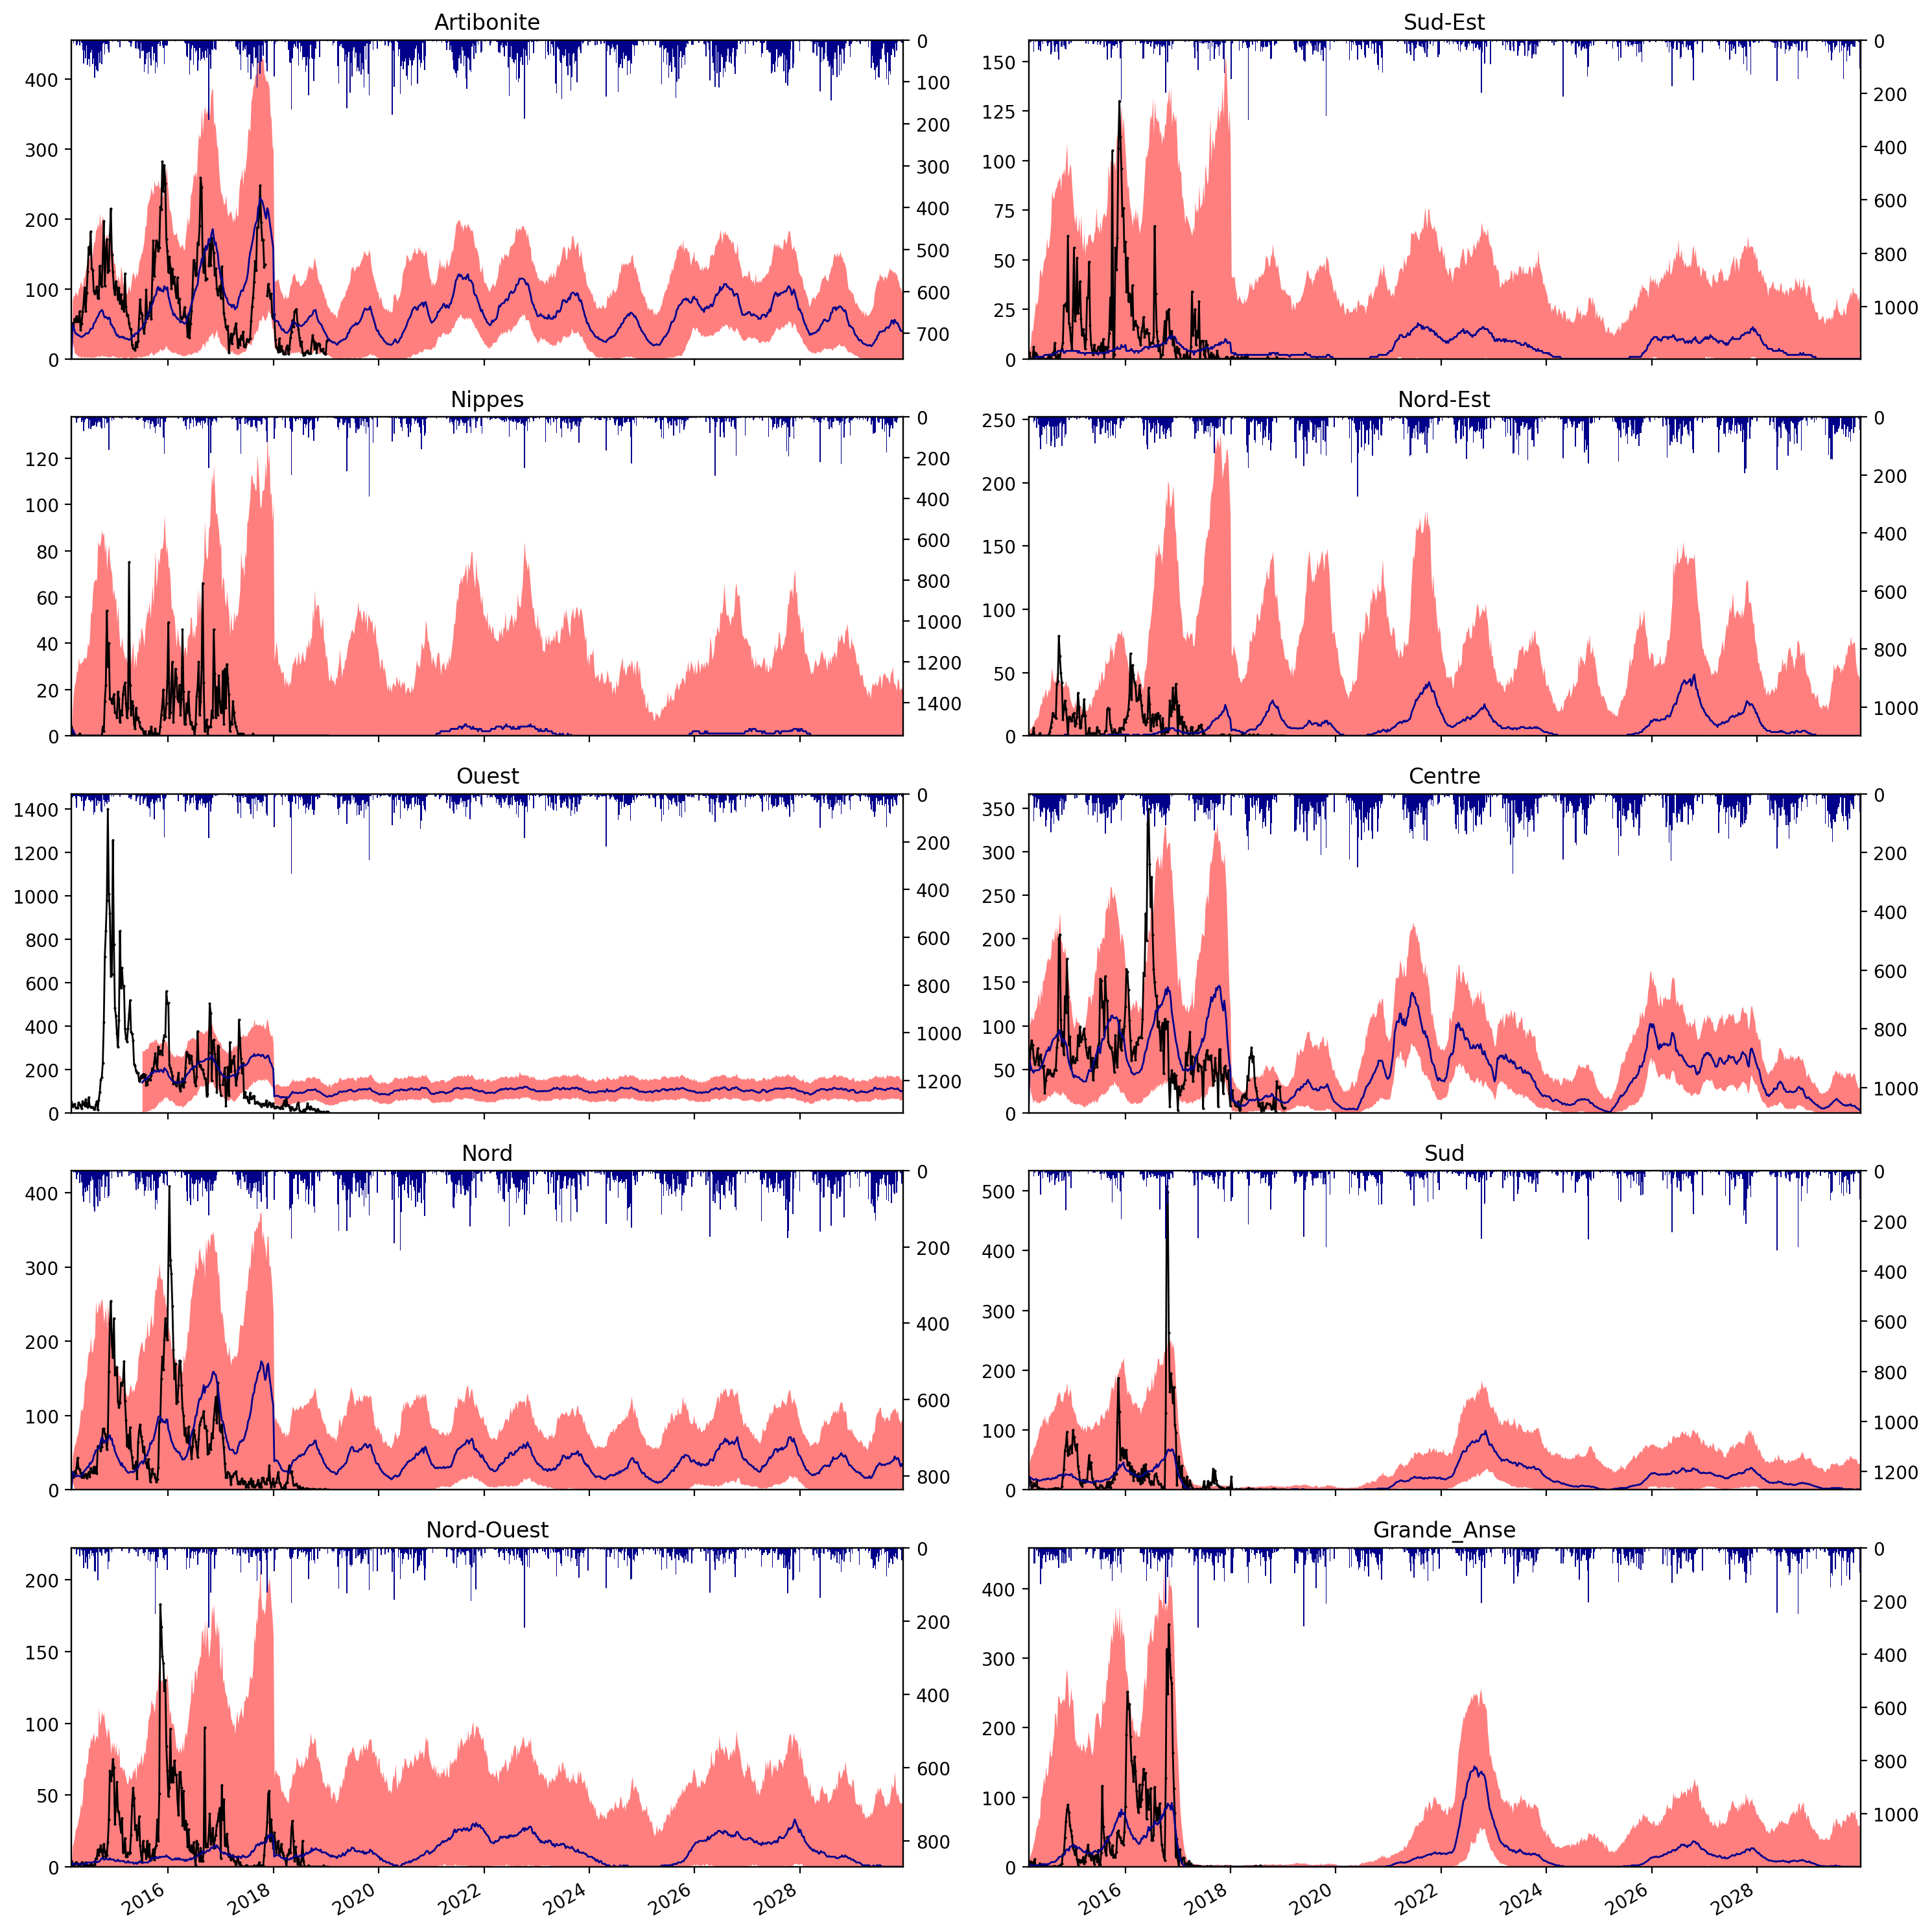

In [211]:
# ti = input_parameters['t_start']
tf = input_parameters['t_end']
tf = t_for

fig, axes = plt.subplots((len(dept_avail))//2, 2, figsize=(15,15), squeeze = True, dpi = 200);
fig.patch.set_facecolor('white')
axes = axes.flatten();
for i, dp in enumerate(dept_avail):

    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][t_start:][ti:tf], marker='.', linestyle='-',color='k', linewidth=1, markersize=1 ) 
    axes[i].fill_between(all_data[dp]['cases']['q05'][ti:tf].index, all_data[dp]['cases']['q05'][ti:tf], all_data[dp]['cases']['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data[dp]['cases']['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(ti,tf, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[ti:tf], label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(4*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)
    #axes[i].legend()

fig.autofmt_xdate()
fig.tight_layout()


### Repartition in the differents compartiments for one departement 

In [ ]:
dp = 'Nord-Est'
ti = input_parameters['t_start']
tf = input_parameters['t_end']
tf = t_for
fig, axes = plt.subplots((len(compartments))//5, 6, figsize=(20,15), squeeze = True);
axes = axes.flatten();
for i, comp in enumerate(compartments):
    axes[i].fill_between(all_data[dp][comp]['q05'][ti:tf].index, all_data[dp][comp]['q05'][ti:tf], all_data[dp][comp]['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data[dp][comp]['mean'][ti:tf], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data[dp][comp]['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'blue') 
    axes[i].set_title(comp)
    #axes[i].legend()
    #axes[i].set_ylim(0)
    
fig.tight_layout()

#### Vaccination scenario

In [198]:
scenario = S25
scenario_str = 'S25'

### Vaccination without mobility to build the mobility file

In [199]:
all_data_vacc = {}

make_genuine_mobility_file()
with mp.Pool(processes=n_proc) as pool:
    for dp, dept_data, _, _ in pool.imap_unordered(run_sim, dept_avail):
        all_data_vacc[dp] = dept_data

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  after removing the cwd from sys.path.
R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ✔ ggplot2 3.1.0       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  

R[write to console]: ✔ ggplot2 3.1.0       ✔ purrr   0.3.2  
✔ tibble  2.1.1       

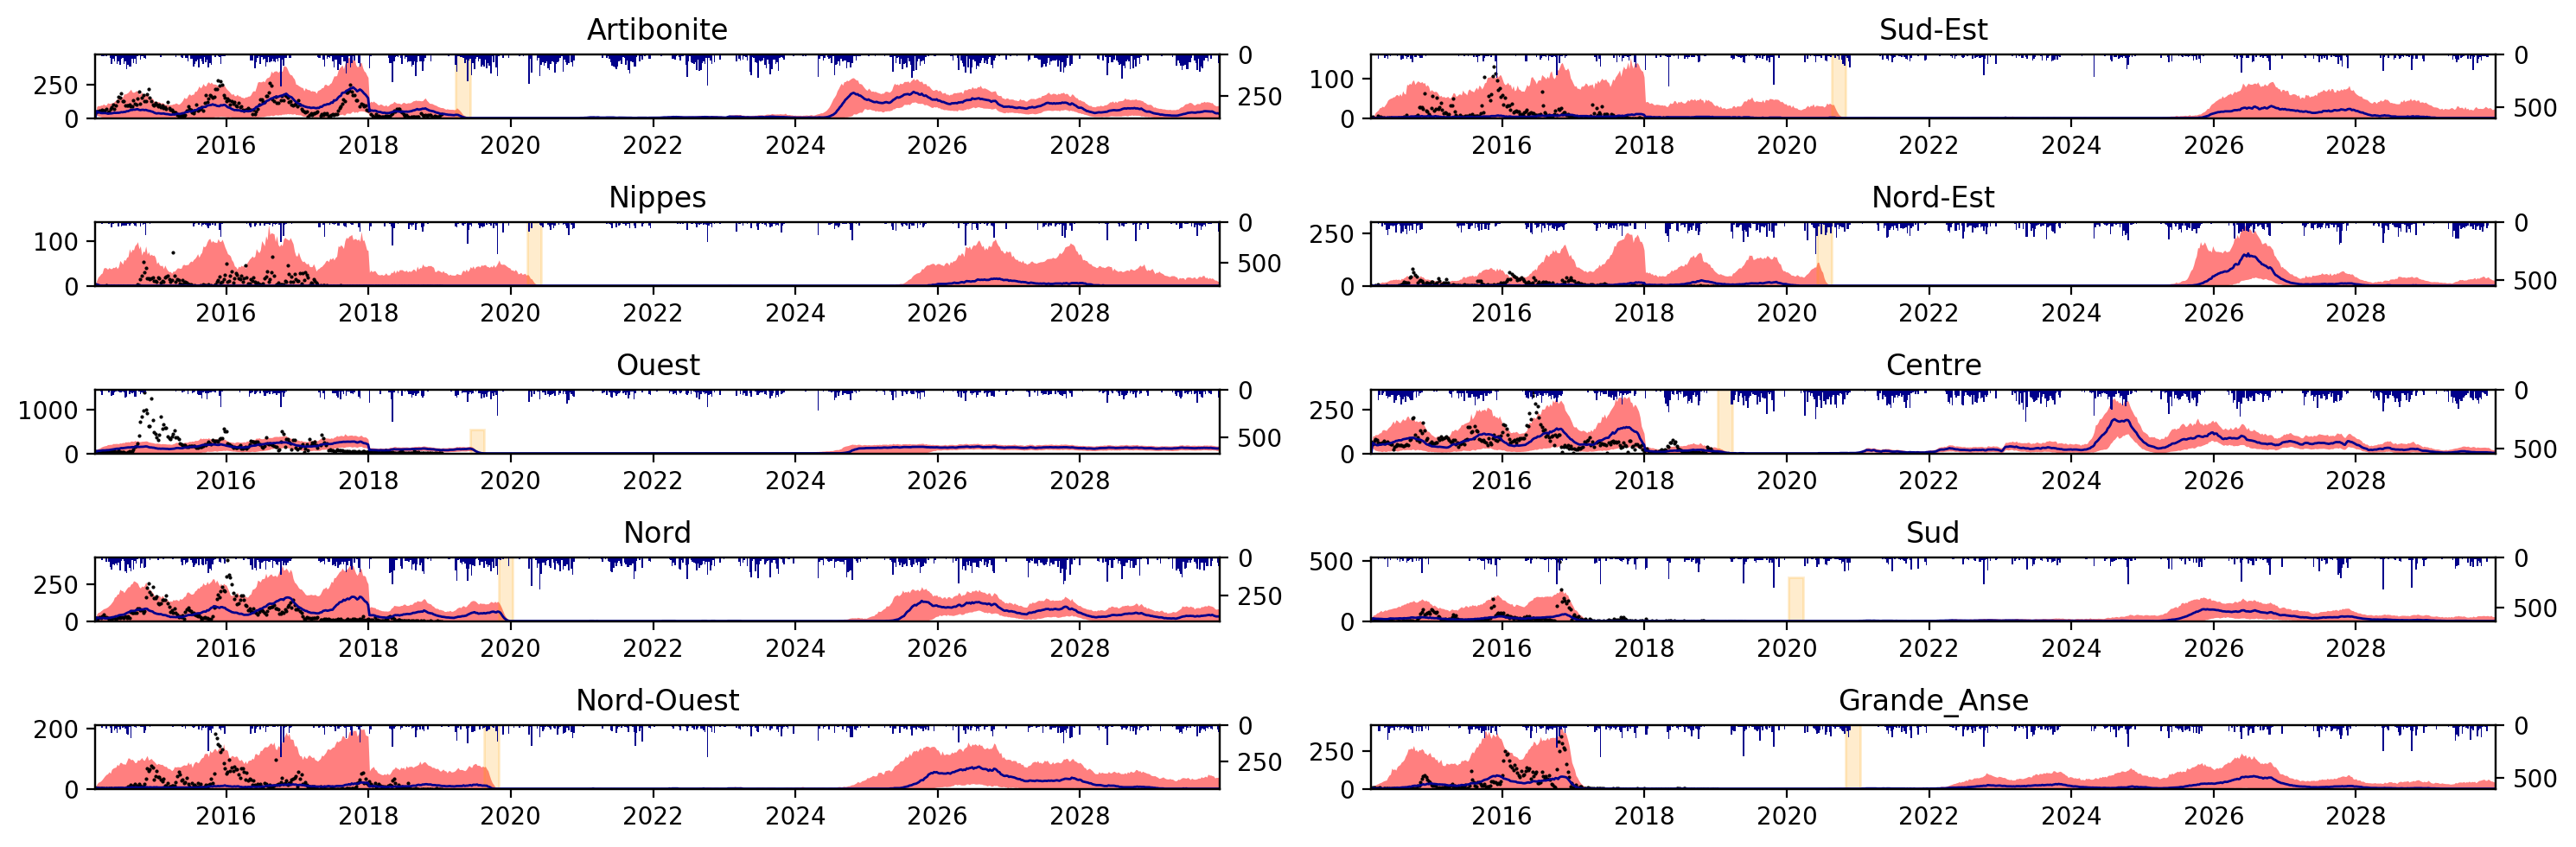

In [200]:
ti = input_parameters['t_start']
#ti = input_parameters['t_end']
tf = t_for

fig, axes = plt.subplots((len(all_data))//2, 2, figsize=(15,5), squeeze = True, dpi = 200);
axes = axes.flatten();
fig.patch.set_facecolor('white')

for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][ti:tf], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 ) 
    
    axes[i].fill_between(all_data_vacc[dp]['cases']['q05'][ti:tf].index, all_data_vacc[dp]['cases']['q05'][ti:tf], all_data_vacc[dp]['cases']['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data_vacc[dp]['cases']['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)    
    # convert to matplotlib date representation
    start = mdates.date2num(scenario.t_vacc_start[dp])
    end = mdates.date2num(scenario.t_vacc_end[dp])
    width = end - start
    rect = Rectangle((start, 0), width, 100+max(all_data_vacc[dp]['cases']['q95']), color='orange', alpha= 0.1)
    axes[i].add_patch(rect) 
    axes[i].add_artist(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/1.5
    #axes[i].annotate(r'Vaccination', (cx, cy), color='black',# weight='bold', 
    #            fontsize=12, ha='center', va='center', rotation='vertical')

fig.tight_layout()

#### Take away mobility to make a mobility file

In [201]:
vacc_init = pd.DataFrame(np.nan, pd.DatetimeIndex(start =  datetime.date(2010,10,23), 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

cases_df =  pd.DataFrame(np.nan, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

covar_mob_novacc = make_genuine_mobility_file()

for dp in dept_avail:
    cases_df[dp] = all_data_vacc[dp]['cases']['q50'][scenario.t_vacc_start[dp]+datetime.timedelta(days = 90) : scenario.t_vacc_start[dp] + datetime.timedelta(days = 200)]

for dp in dept_name:
    if dp in dept_avail:
        vacc_init[dp] = covar_mob_novacc[dp][datetime.date(2010,10,23):scenario.t_vacc_start[dp]]   # 
        vacc_init[dp].fillna(cases_df[dp].mean(), inplace = True)
        print(dp, cases_df[dp].mean())
    else:
        vacc_init[dp] = covar_mob_novacc[dp]  #0
    
vacc_init.to_csv('vacc_init' + scenario_str +  '.csv', index_label='date')

Artibonite 0.0
Centre 0.3125
Grande_Anse 1.625
Nippes 0.0
Nord 0.0
Nord-Est 0.0
Nord-Ouest 0.0
Ouest 0.0
Sud 0.0
Sud-Est 0.0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  after removing the cwd from sys.path.


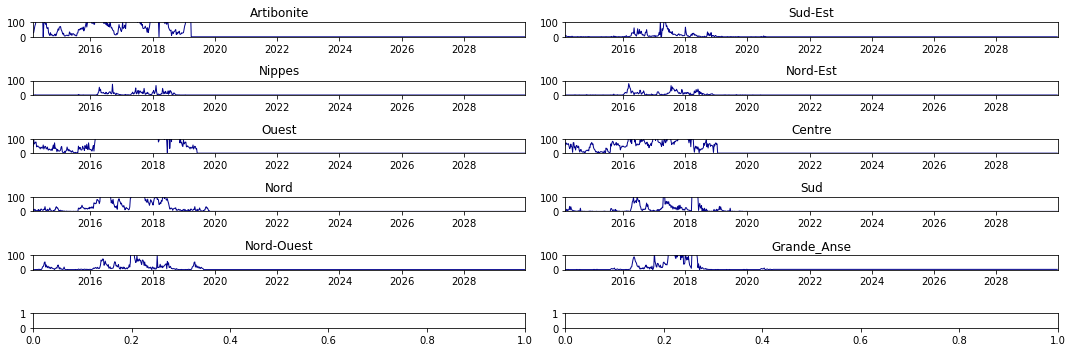

In [202]:
fig, axes = plt.subplots((len(all_data))//2+1, 2, figsize=(15,5), squeeze = True);
axes = axes.flatten();
fig.patch.set_facecolor('white')

for i, dp in enumerate(dept_avail):
    axes[i].plot(vacc_init[dp], alpha = 5,linestyle='-', linewidth = 1, color = 'darkblue')
    #axes[i].plot(covar_init[dp], alpha = 1,linestyle='-', linewidth = 1, color = 'red')
    axes[i].set_title(dp)
    axes[i].set_ylim(0,100)
    axes[i].set_xlim(t_start, t_for)

fig.tight_layout()

### Projection with mobility

In [203]:
vacc_init = pd.read_csv('vacc_init' + scenario_str +  '.csv', index_col = 0, parse_dates = True)
vacc_init.to_csv('covar_mob.csv', index_label='date')

all_data_vacc_mob = {}

with mp.Pool(processes=n_proc) as pool:
    for dp, dept_data, _, _ in pool.imap_unordered(run_sim, dept_avail):
        all_data_vacc_mob[dp] = dept_data


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ✔ ggplot2 3.1.0       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  

R[write to console]: ✔ ggplot2 3.1.0       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  

R[write to console]: ✔ ggplot2 3.1.0       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3     

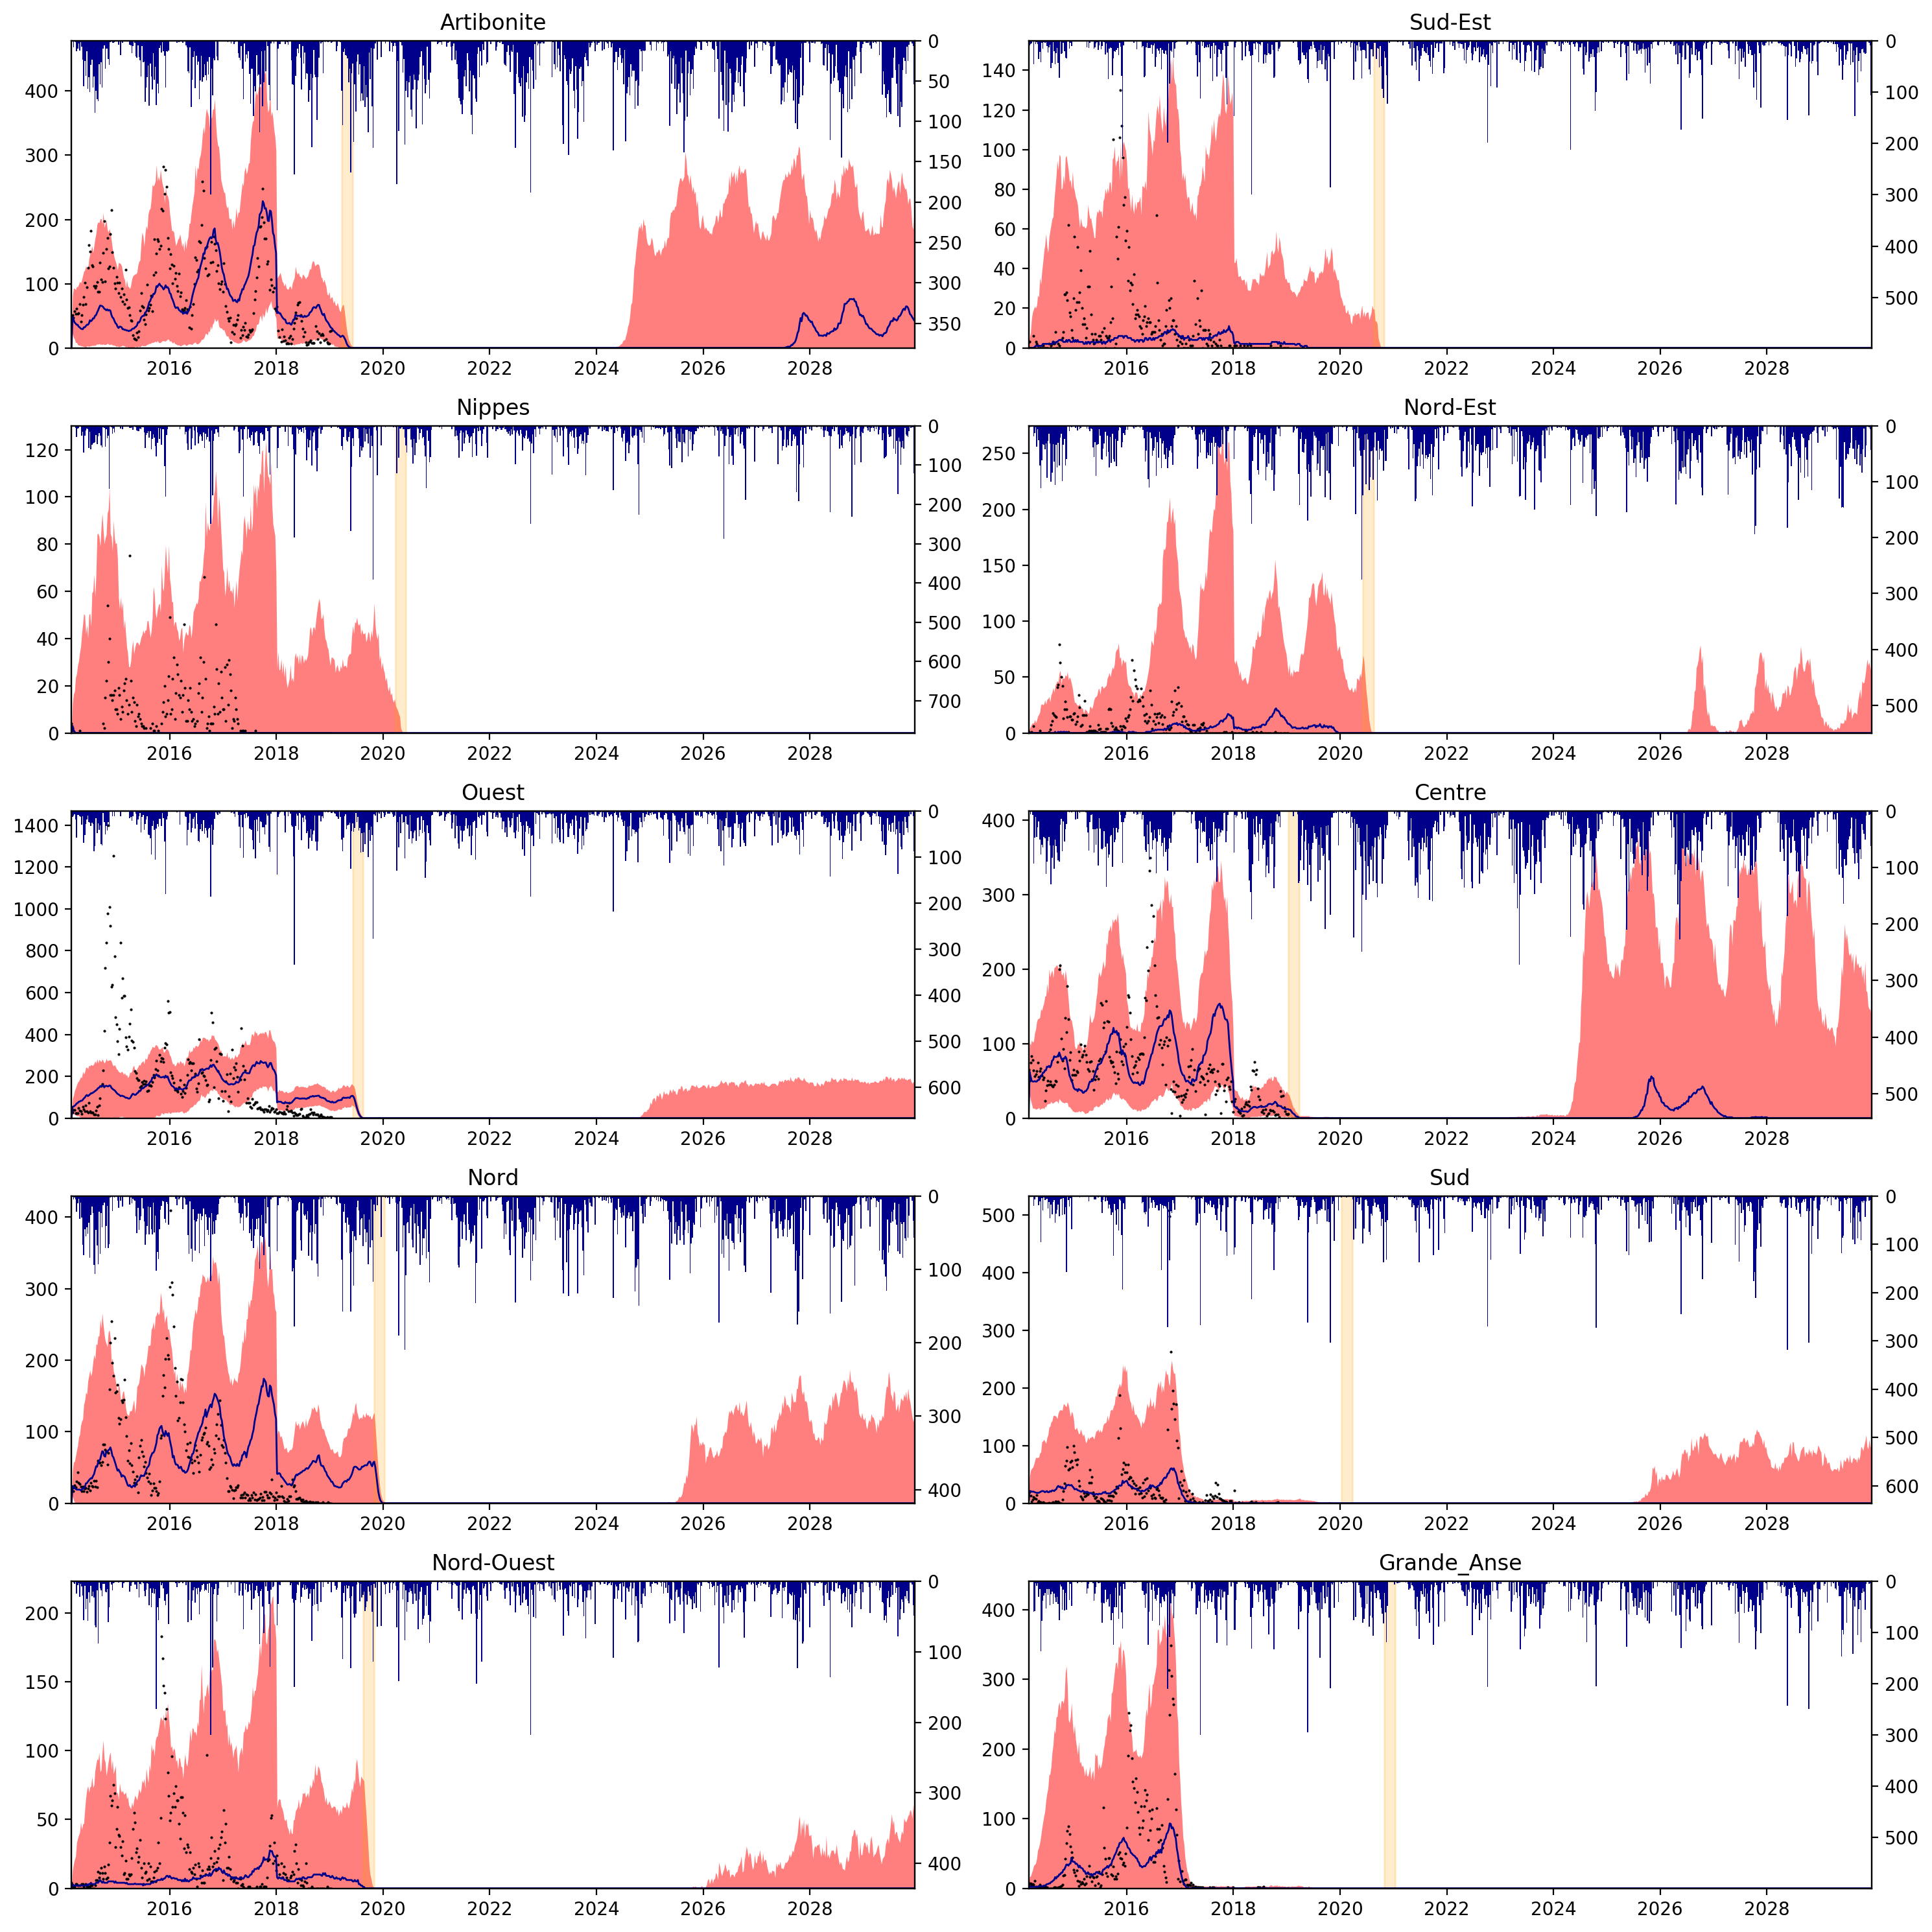

In [204]:
ti = input_parameters['t_start']
#ti = input_parameters['t_end']
tf = t_for

fig, axes = plt.subplots((len(all_data))//2, 2, figsize=(15,15), squeeze = True, dpi = 200);
axes = axes.flatten();
fig.patch.set_facecolor('white')

for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][ti:tf], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 ) 
    axes[i].fill_between(all_data_vacc_mob[dp]['cases']['q05'][ti:tf].index, all_data_vacc_mob[dp]['cases']['q05'][ti:tf], all_data_vacc_mob[dp]['cases']['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data_vacc_mob[dp]['cases']['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)
    
    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)
    #if dp in ['Artibonite', 'Centre', 'Ouest']:
    if dp in dept_avail:
        # convert to matplotlib date representation
        start = mdates.date2num(scenario.t_vacc_start[dp])
        end = mdates.date2num(scenario.t_vacc_end[dp])
        width = end - start
        rect = Rectangle((start, 0), width, 1000+max(all_data_vacc[dp]['cases']['q95']), color='orange', alpha= 0.1)
        axes[i].add_patch(rect) 
        axes[i].add_artist(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/1.5

fig.tight_layout()

#### Comparison

In [ ]:
ti = input_parameters['t_start']
#ti = input_parameters['t_end']
tf = t_for

fig, axes = plt.subplots((len(all_data))//2, 2, figsize=(15,15), squeeze = True, dpi = 200);
axes = axes.flatten();
fig.patch.set_facecolor('white')

for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][ti:tf], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 )
    
    axes[i].plot(all_data[dp]['cases']['q50'][ti:tf],          alpha = 1, linestyle='-', linewidth = 1, color = 'darkblue')
    axes[i].plot(all_data_vacc[dp]['cases']['q50'][ti:tf],     alpha = 1, linestyle='-', linewidth = 4, color = 'green')
    axes[i].plot(all_data_vacc_mob[dp]['cases']['q50'][ti:tf], alpha = 1, linestyle='-', linewidth = 2, color = 'red')
    
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)    
    # convert to matplotlib date representation
    start = mdates.date2num(scenario.t_vacc_start[dp])
    end = mdates.date2num(scenario.t_vacc_end[dp])
    width = end - start
    rect = Rectangle((start, 0), width, 100+max(all_data_vacc[dp]['cases']['q95']), color='orange', alpha= 0.1)
    axes[i].add_patch(rect) 
    axes[i].add_artist(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/1.5

fig.tight_layout()

## Nationwide plot

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  if __name__ == '__main__':


(735780.0, 737071.0)

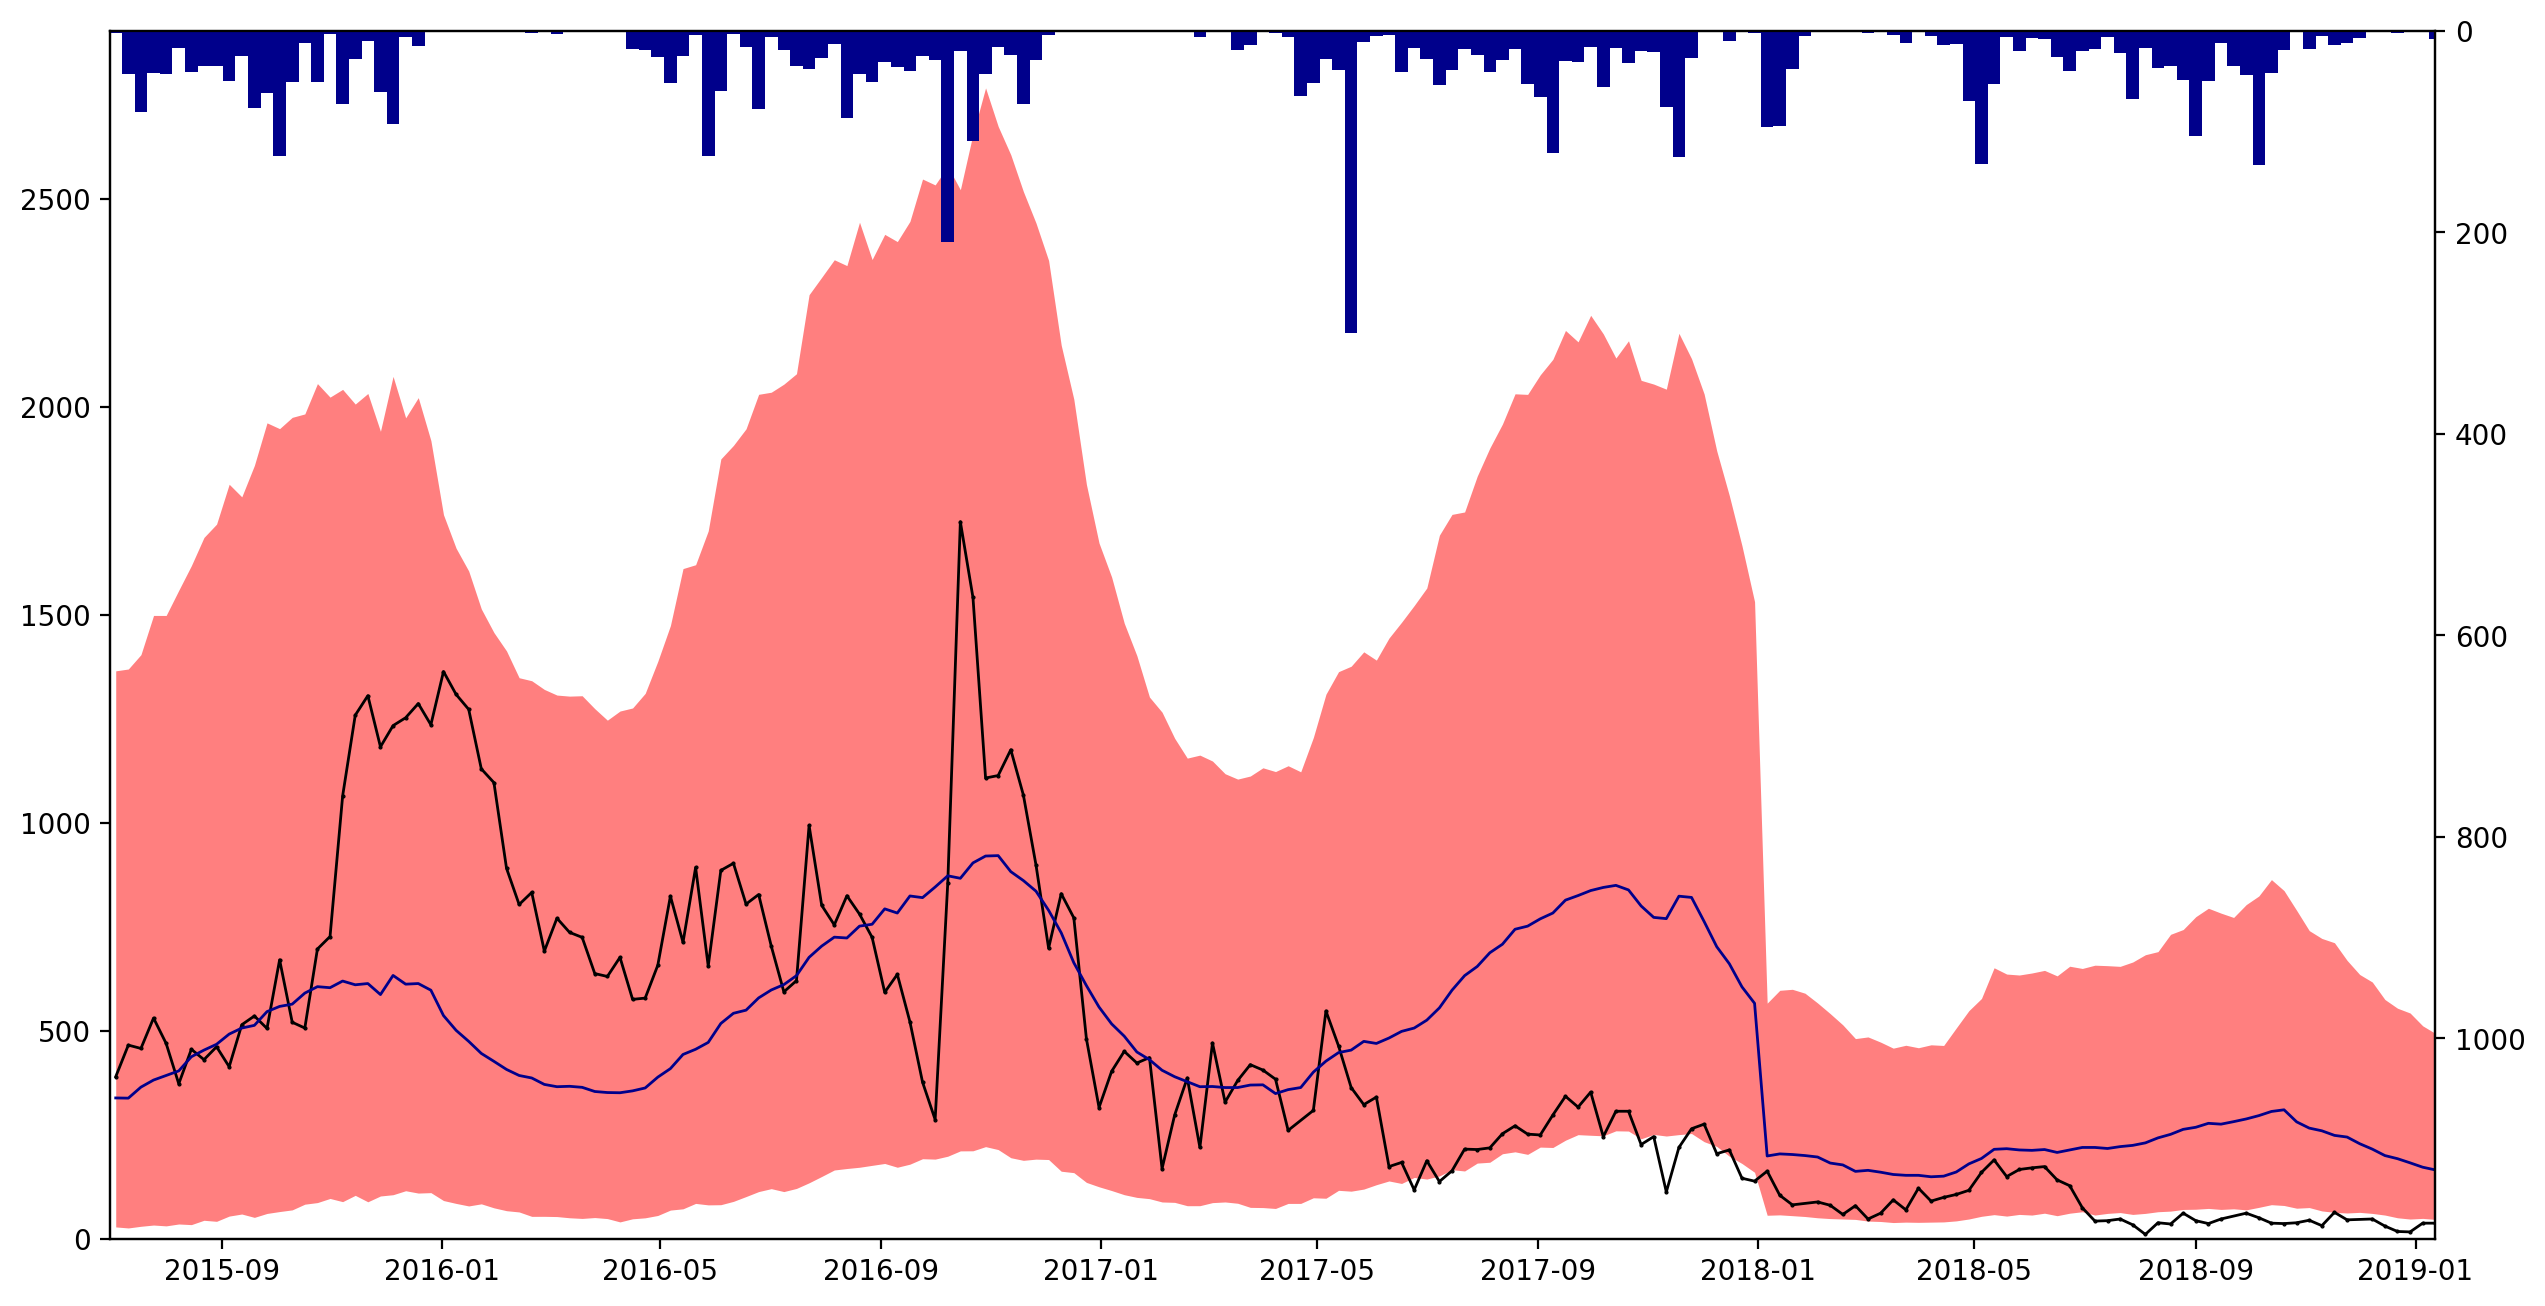

In [218]:
to_plot = all_data
plot_all_q50 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

plot_all_q05 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

plot_all_q95 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

for dp in dept_avail:
            plot_all_q50[dp] = to_plot[dp]['cases']['q50']
            plot_all_q95[dp] = to_plot[dp]['cases']['q95']
            plot_all_q05[dp] = to_plot[dp]['cases']['q05']

plot_all = pd.concat([plot_all_q05.sum(axis=1), plot_all_q50.sum(axis=1), plot_all_q95.sum(axis=1)], axis = 1, keys = ['q05', 'q50', 'q95'])


ti = input_parameters['t_start']
ti = datetime.date(2015,7,1)
tf = input_parameters['t_end']
#tf = t_for

fig, axes = plt.subplots(1, 1, figsize=(15,8), squeeze = True, dpi = 200);
fig.patch.set_facecolor('white')
axt =  axes.twinx()
axes.plot(cases.sum(axis=1)[t_start:][ti:tf], marker='.', linestyle='-',color='k', linewidth=1, markersize=1 ) 
axes.fill_between(plot_all['q05'][ti:tf].index, plot_all['q05'][ti:tf], plot_all['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
axes.plot(plot_all['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
axt.bar(pd.date_range(ti,tf, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[ti:tf], label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

axes.set_ylim(0)
axt.set_ylim(4*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
axes.set_xlim(ti, tf)
    
#fig.tight_layout()

### Save results !

In [212]:
to_save = all_data#_vacc_mob
#scenario_str = 'S0'
csv_all_q50 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

csv_all_q05 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

csv_all_q95 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)


for dp in dept_avail:
        csv_all_q50[dp] = to_save[dp]['cases']['q50']
        csv_all_q95[dp] = to_save[dp]['cases']['q95']
        csv_all_q05[dp] = to_save[dp]['cases']['q05']
        
csv_all_q05.to_csv(scenario_str + '_q05.csv', index_label='date')
csv_all_q95.to_csv(scenario_str + '_q95.csv', index_label='date')
csv_all_q50.to_csv(scenario_str + '_q50.csv', index_label='date')
pd.concat([csv_all_q05.sum(axis=1), csv_all_q50.sum(axis=1), csv_all_q95.sum(axis=1)], axis = 1, keys = ['q05', 'q50', 'q95']).to_csv(scenario_str + '_national.csv', index_label='date')

for dp in dept_avail:
        csv_all_q50[dp] = to_save[dp]['C']['q50']
        csv_all_q95[dp] = to_save[dp]['C']['q95']
        csv_all_q05[dp] = to_save[dp]['C']['q05']
        
csv_all_q05.to_csv(scenario_str + '_q05_s.csv', index_label='date')
csv_all_q95.to_csv(scenario_str + '_q95_s.csv', index_label='date')
csv_all_q50.to_csv(scenario_str + '_q50_s.csv', index_label='date')
pd.concat([csv_all_q05.sum(axis=1), csv_all_q50.sum(axis=1), csv_all_q95.sum(axis=1)], axis = 1, keys = ['q05', 'q50', 'q95']).to_csv(scenario_str + '_national_s.csv', index_label='date')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  # Remove the CWD from sys.path while we load stuff.


# MISC

In [ ]:
all_data['Artibonite']['B']